# <font color=blue>  COVID analysis for neighbourhoods in New York city </font>

## Problem Statement : 
Is there a correlation between various population demographic factors and COVID infection rate spreads in New York city ? Can this be proven based on data correlations and visualisations?

## Background: 
COVID has spread across the globe. The infections rates and mortality rates are different in different places. For this exercise I would like to analyse covid infection rates and find correlation with population demographics like race and income groups.

## Data Description
### For this analysis I am listing down the sources and types of data I would be using
1. CDC COVID data tabled neighbourhood wise
2. NYC municipal data in geoJson format detailing the neighbourhood geo data.
3. NYC census data for various demographics like race, sex, income groups.

I would be doing a minor cleanup since the data is from multiple different sources. Key here would be the Modified CTA is a modified ZIP code data

https://github.com/nychealth/coronavirus-data

## Methodology
## STEP 1 -- DATA PREPARATION
### Import the relevant libraries for analysis

In [94]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
#mpl.style.use('ggplot')

### Dataset 1 - Covid case rates by NY neighbourhood

In [81]:
url = 'https://github.com/nychealth/coronavirus-data/blob/master/data-by-modzcta.csv'
webList = pd.read_html(url, header=0)
dfByLocation=webList[0]
dfByLocation.drop(columns = ['Unnamed: 0'],axis=1,inplace=True)
dfByLocation.head()

MODIFIED_ZCTA                        NEIGHBORHOOD_NAME BOROUGH_GROUP  \
0          10001               Chelsea/NoMad/West Chelsea     Manhattan   
1          10002                Chinatown/Lower East Side     Manhattan   
2          10003  East Village/Gramercy/Greenwich Village     Manhattan   
3          10004                       Financial District     Manhattan   
4          10005                       Financial District     Manhattan   

   COVID_CASE_COUNT  COVID_CASE_RATE  POP_DENOMINATOR  COVID_DEATH_COUNT  \
0               381          1616.94         23563.03                 22   
1              1081          1408.37         76755.41                152   
2               463           860.57         53801.62                 34   
3                32           876.57          3650.61                  1   
4                64           762.26          8396.11                  2   

   COVID_DEATH_RATE  PERCENT_POSITIVE  TOTAL_COVID_TESTS  
0             93.37             11.30               3372  
1            198.03             15.89               6803  
2             63.20              8.71               5316  
3             27.39              9.22                347  
4             23.82              8.27                774

#### Modify dataframe for the required columns

In [69]:
dfByLocationTrim=dfByLocation[['MODIFIED_ZCTA','NEIGHBORHOOD_NAME','BOROUGH_GROUP','COVID_CASE_RATE']]
dfByLocationTrim.loc[:,'MODIFIED_ZCTA']= dfByLocationTrim[['MODIFIED_ZCTA']].astype("str")
dfByLocationTrim.head()

MODIFIED_ZCTA                        NEIGHBORHOOD_NAME BOROUGH_GROUP  \
0         10001               Chelsea/NoMad/West Chelsea     Manhattan   
1         10002                Chinatown/Lower East Side     Manhattan   
2         10003  East Village/Gramercy/Greenwich Village     Manhattan   
3         10004                       Financial District     Manhattan   
4         10005                       Financial District     Manhattan   

   COVID_CASE_RATE  
0          1616.94  
1          1408.37  
2           860.57  
3           876.57  
4           762.26

### Dataset 2 - NY neighbourhood demoraphic data

In [70]:
filename= "Demographic_Statistics_By_Zip_Code.csv"
dfDemographic = pd.read_csv(filename)
dfDemographic.head()

JURISDICTION NAME  COUNT PARTICIPANTS  COUNT FEMALE  PERCENT FEMALE  \
0              10001                  44            22            0.50   
1              10002                  35            19            0.54   
2              10003                   1             1            1.00   
3              10004                   0             0            0.00   
4              10005                   2             2            1.00   

   COUNT MALE  PERCENT MALE  COUNT GENDER UNKNOWN  PERCENT GENDER UNKNOWN  \
0          22          0.50                     0                       0   
1          16          0.46                     0                       0   
2           0          0.00                     0                       0   
3           0          0.00                     0                       0   
4           0          0.00                     0                       0   

   COUNT GENDER TOTAL  PERCENT GENDER TOTAL  ...  COUNT CITIZEN STATUS TOTAL  \
0                  44                   100  ...                          44   
1                  35                   100  ...                          35   
2                   1                   100  ...                           1   
3                   0                     0  ...                           0   
4                   2                   100  ...                           2   

   PERCENT CITIZEN STATUS TOTAL  COUNT RECEIVES PUBLIC ASSISTANCE  \
0                           100                                20   
1                           100                                 2   
2                           100                                 0   
3                             0                                 0   
4                           100                                 0   

   PERCENT RECEIVES PUBLIC ASSISTANCE  COUNT NRECEIVES PUBLIC ASSISTANCE  \
0                                0.45                                 24   
1                                0.06                                 33   
2                                0.00                                  1   
3                                0.00                                  0   
4                                0.00                                  2   

   PERCENT NRECEIVES PUBLIC ASSISTANCE  COUNT PUBLIC ASSISTANCE UNKNOWN  \
0                                 0.55                                0   
1                                 0.94                                0   
2                                 1.00                                0   
3                                 0.00                                0   
4                                 1.00                                0   

   PERCENT PUBLIC ASSISTANCE UNKNOWN  COUNT PUBLIC ASSISTANCE TOTAL  \
0                                  0                             44   
1                                  0                             35   
2                                  0                              1   
3                                  0                              0   
4                                  0                              2   

   PERCENT PUBLIC ASSISTANCE TOTAL  
0                              100  
1                              100  
2                              100  
3                                0  
4                              100  

[5 rows x 46 columns]

### Modifying the dataframe to fit the analysis needs
The data set can be used to create a combined column for pecentage of population thats 'coloured'. Also the column that shows the percentage of population living on public assistance. For the lack of a better metric, this can be used to signify low income group populaiton. 

In [71]:
dfDemographic.loc[:,'Percent_Coloured'] = dfDemographic['PERCENT PACIFIC ISLANDER']+dfDemographic['PERCENT HISPANIC LATINO']+dfDemographic['PERCENT AMERICAN INDIAN']+dfDemographic['PERCENT ASIAN NON HISPANIC']+dfDemographic['PERCENT BLACK NON HISPANIC']
dfDemographic.loc[:,'MODIFIED_ZCTA'] = dfDemographic['JURISDICTION NAME']
dfDemographic[['MODIFIED_ZCTA']]= dfDemographic[['MODIFIED_ZCTA']].astype("str")
dfDemographic=dfDemographic.drop(['JURISDICTION NAME', 'COUNT PARTICIPANTS', 'COUNT FEMALE',
       'PERCENT FEMALE', 'COUNT MALE', 'PERCENT MALE', 'COUNT GENDER UNKNOWN',
       'PERCENT GENDER UNKNOWN', 'COUNT GENDER TOTAL', 'PERCENT GENDER TOTAL',
       'COUNT PACIFIC ISLANDER', 'PERCENT PACIFIC ISLANDER',
       'COUNT HISPANIC LATINO', 'PERCENT HISPANIC LATINO',
       'COUNT AMERICAN INDIAN', 'PERCENT AMERICAN INDIAN',
       'COUNT ASIAN NON HISPANIC', 'PERCENT ASIAN NON HISPANIC',
       'COUNT WHITE NON HISPANIC', 'PERCENT WHITE NON HISPANIC',
       'COUNT BLACK NON HISPANIC', 'PERCENT BLACK NON HISPANIC',
       'COUNT OTHER ETHNICITY', 'PERCENT OTHER ETHNICITY',
       'COUNT ETHNICITY UNKNOWN', 'PERCENT ETHNICITY UNKNOWN',
       'COUNT ETHNICITY TOTAL', 'PERCENT ETHNICITY TOTAL',
       'COUNT PERMANENT RESIDENT ALIEN', 'PERCENT PERMANENT RESIDENT ALIEN',
       'COUNT US CITIZEN', 'PERCENT US CITIZEN', 'COUNT OTHER CITIZEN STATUS',
       'PERCENT OTHER CITIZEN STATUS', 'COUNT CITIZEN STATUS UNKNOWN',
       'PERCENT CITIZEN STATUS UNKNOWN', 'COUNT CITIZEN STATUS TOTAL',
       'PERCENT CITIZEN STATUS TOTAL', 'COUNT RECEIVES PUBLIC ASSISTANCE',
       'COUNT NRECEIVES PUBLIC ASSISTANCE',
       'PERCENT NRECEIVES PUBLIC ASSISTANCE',
       'COUNT PUBLIC ASSISTANCE UNKNOWN', 'PERCENT PUBLIC ASSISTANCE UNKNOWN',
       'COUNT PUBLIC ASSISTANCE TOTAL', 'PERCENT PUBLIC ASSISTANCE TOTAL'],axis=1)
dfDemographic.head()

PERCENT RECEIVES PUBLIC ASSISTANCE  Percent_Coloured MODIFIED_ZCTA
0                                0.45              0.91         10001
1                                0.06              0.83         10002
2                                0.00              1.00         10003
3                                0.00              0.00         10004
4                                0.00              1.00         10005

### Joining the two data sets into one to do a combined analysis

In [72]:
dfByLocationTrim = pd.merge(dfByLocationTrim, dfDemographic, how='inner', on = 'MODIFIED_ZCTA')
dfByLocationTrim.head()

MODIFIED_ZCTA                        NEIGHBORHOOD_NAME BOROUGH_GROUP  \
0         10001               Chelsea/NoMad/West Chelsea     Manhattan   
1         10002                Chinatown/Lower East Side     Manhattan   
2         10003  East Village/Gramercy/Greenwich Village     Manhattan   
3         10004                       Financial District     Manhattan   
4         10005                       Financial District     Manhattan   

   COVID_CASE_RATE  PERCENT RECEIVES PUBLIC ASSISTANCE  Percent_Coloured  
0          1616.94                                0.45              0.91  
1          1408.37                                0.06              0.83  
2           860.57                                0.00              1.00  
3           876.57                                0.00              0.00  
4           762.26                                0.00              1.00

## STEP 2 -- Analysis

### Lets check correlation figures
As is seen below, there is not clear correlation between these attributes.

In [84]:
dfByLocationTrim.corr(method ='pearson')

COVID_CASE_RATE  \
COVID_CASE_RATE                            1.000000   
PERCENT RECEIVES PUBLIC ASSISTANCE         0.086285   
Percent_Coloured                           0.079274   

                                    PERCENT RECEIVES PUBLIC ASSISTANCE  \
COVID_CASE_RATE                                               0.086285   
PERCENT RECEIVES PUBLIC ASSISTANCE                            1.000000   
Percent_Coloured                                              0.466413   

                                    Percent_Coloured  
COVID_CASE_RATE                             0.079274  
PERCENT RECEIVES PUBLIC ASSISTANCE          0.466413  
Percent_Coloured                            1.000000

### Checking this visually
Visually as well there is no clear indication of correlation. there could possible me a combination of factors.

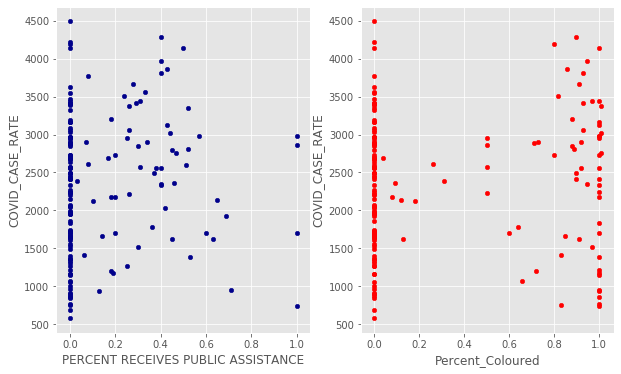

In [103]:
fig = plt.figure() # create figure
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2) 

# Subplot 1: Box plot
dfByLocationTrim.plot(kind='scatter', x='PERCENT RECEIVES PUBLIC ASSISTANCE', y='COVID_CASE_RATE', figsize=(10, 6), color='darkblue',ax=ax0)
# Subplot 2: Box plot
dfByLocationTrim.plot(kind='scatter', x='Percent_Coloured', y='COVID_CASE_RATE', figsize=(10, 6), color='red',ax=ax1)

plt.show()

## STEP 3 -- Geographic Analysis

### Lets check COVID hotspots vs demographic popluation spread within NY neighbourhoods

#### Download the NY geoJson data file

In [121]:
!wget --quiet https://raw.githubusercontent.com/nychealth/coronavirus-data/master/Geography-resources/MODZCTA_2010_WGS1984.geo.json -O nygeo.json

### Creating a Folium Choropeth layer for Covid infection rate (scale - Yellow ---> Red)

In [104]:
# Setting threshold for the scale
threshold_scale = np.linspace(dfByLocationTrim['COVID_CASE_RATE'].min(),
                              dfByLocationTrim['COVID_CASE_RATE'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1 

#Create Visualisation map for Covid infection rate
nygeo = r'nygeo.json' # geojson file
ny_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
# generate choropleth map using the COVID infection rates
covid_rate = ny_map.choropleth(
    geo_data=nygeo,
    data=dfByLocationTrim,
    columns=['MODIFIED_ZCTA', 'COVID_CASE_RATE'],
    key_on='feature.properties.MODZCTA',
    threshold_scale=threshold_scale,
    fill_color='YlGn', 
    name='Covid Rate',
    fill_opacity=0.4, 
    line_opacity=0.2,
    legend_name='Covid cases per 100,000',
    reset = True
)

### Creating a Folium Choropeth layer for neighbourhoods with population of colour. (scale - Light Blue ---> Deep Purple \m/ )

#### The two layers are Blended together and visually show a correlation between demographic and the covid infection rate. 
#### Deeper RED + Blue shows magenta and therefore is a combination of high covid infection rate and high percentage of population of colour.
#### The layer selector can be used to switch between the layers on the choropleth maps.

In [107]:
# generate choropleth map using the COVID infection rates
ny_map.choropleth(
    geo_data=nygeo,
    data=dfByLocationTrim,
    columns=['MODIFIED_ZCTA', 'Percent_Coloured'],
    key_on='feature.properties.MODZCTA',
    #threshold_scale=threshold_scale,
    fill_color='BuGn', 
    name='Coloured Population',
    fill_opacity=0.4, 
    line_opacity=0.1,
    legend_name='Covid cases per 100,000',
    reset = True
)
folium.LayerControl().add_to(ny_map)
# display map
ny_map